In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
import cv2
import os

In [3]:

data_dir ='train'


# Gather image filenames
image_filenames = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

# Split the dataset
train_filenames, val_filenames = train_test_split(image_filenames, test_size=0.15, random_state=42)

print(f'Training set size: {len(train_filenames)}')
print(f'Validation set size: {len(val_filenames)}')

Training set size: 5292
Validation set size: 934


### Load Data

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, data_dir, filenames, transform=None):
        self.data_dir = data_dir
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        image_path = os.path.join(self.data_dir, img_name)
        mask_name = img_name.replace('.jpg', '.png').replace('_sat', '_mask')
        mask_path = os.path.join(self.data_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  #mask is a single channel image

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Binarize the mask
        mask = (mask > 0.5).float() 

        return image, mask

# Example transform to convert images to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = SegmentationDataset(data_dir=data_dir, filenames=train_filenames, transform=transform)
val_dataset = SegmentationDataset(data_dir=data_dir, filenames=val_filenames, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


In [5]:
def visualize_data(images, masks, num_images=2):

    batch_indices = np.random.choice(images.size(0), num_images, replace=False)
    batch_images = images[batch_indices]
    batch_masks = masks[batch_indices]

    # Create a grid of images and masks
    grid_images = make_grid(batch_images, nrow=num_images, normalize=True)
    grid_masks = make_grid(batch_masks, nrow=num_images, normalize=True)

    # Convert the grid images and masks to numpy arrays
    grid_images = grid_images.numpy().transpose(1, 2, 0)
    grid_masks = grid_masks.numpy().transpose(1, 2, 0)

    # Plot the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grid_images)
    plt.title('Images')
    plt.subplot(1, 2, 2)
    plt.imshow(grid_masks)
    plt.title('Masks')
    plt.show()

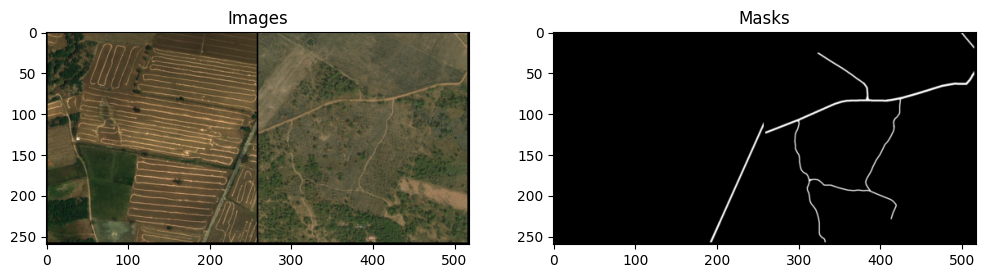

In [12]:
images, masks = next(iter(train_loader))
visualize_data(images, masks)

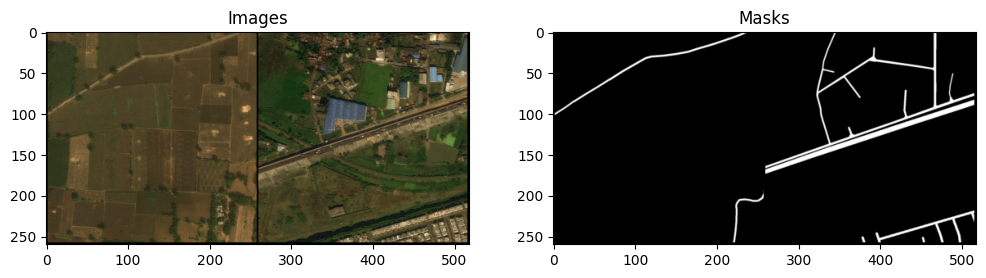

In [13]:
images, masks = next(iter(val_loader))
visualize_data(images, masks)

### Model architecture

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        #print(x2.shape)
        x3 = self.decoder(x2)
        #print(x3.shape)
        return x3

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=1).to(device)
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): ConvTranspose2d(1, 1, kernel_size=(2, 2), strid

#### The metrices we are going to use are IOU(Intersection over Union) and Dice Coefficient
A Dice/IOU score of 1 indicates perfect overlap between the predicted and ground truth segmentations.
A Dice/IOU score of 0 indicates no overlap.

In [8]:
# IoU and Dice Coefficient functions
def iou(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Convert predictions to binary
    target = target > 0.5  # Convert targets to binary
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def dice_coeff(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Convert predictions to binary
    target = target > 0.5  # Convert targets to binary
    intersection = (pred & target).float().sum((1, 2))
    dice = (2. * intersection + smooth) / (pred.float().sum((1, 2)) + target.float().sum((1, 2)) + smooth)
    return dice.mean()


In [9]:
lr = 0.001
num_epochs = 25

#loss function with opt
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Train the model on train set, checking validation scores on validation set

In [10]:
from tqdm import tqdm
# early_stopping = EarlyStopping(patience=5, verbose=True)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        running_iou += iou(preds, masks) * images.size(0)
        running_dice += dice_coeff(preds, masks) * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader.dataset)
    epoch_dice = running_dice / len(train_loader.dataset)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, Dice: {epoch_dice:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            val_iou += iou(preds, masks) * images.size(0)
            val_dice += dice_coeff(preds, masks) * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)
    val_dice /= len(val_loader.dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation Dice: {val_dice:.4f}')


In [61]:
for epoch in range(num_epochs):
    train(model, train_loader, val_loader, criterion, optimizer, device, epoch)

100%|██████████| 1323/1323 [00:36<00:00, 36.56it/s]


Epoch 1, Loss: 0.2297, IoU: 0.1630, Dice: 0.1669


100%|██████████| 234/234 [00:06<00:00, 35.97it/s]


Validation Loss: 0.1370, Validation IoU: 0.1905, Validation Dice: 0.1987


100%|██████████| 1323/1323 [00:36<00:00, 36.49it/s]


Epoch 2, Loss: 0.1234, IoU: 0.2357, Dice: 0.2626


100%|██████████| 234/234 [00:06<00:00, 36.06it/s]


Validation Loss: 0.1199, Validation IoU: 0.3197, Validation Dice: 0.3855


100%|██████████| 1323/1323 [00:35<00:00, 36.80it/s]


Epoch 3, Loss: 0.1131, IoU: 0.2952, Dice: 0.3451


100%|██████████| 234/234 [00:06<00:00, 35.42it/s]


Validation Loss: 0.1105, Validation IoU: 0.3330, Validation Dice: 0.3955


100%|██████████| 1323/1323 [00:36<00:00, 36.47it/s]


Epoch 4, Loss: 0.1057, IoU: 0.3313, Dice: 0.3915


100%|██████████| 234/234 [00:06<00:00, 35.75it/s]


Validation Loss: 0.1071, Validation IoU: 0.3607, Validation Dice: 0.4316


100%|██████████| 1323/1323 [00:36<00:00, 36.56it/s]


Epoch 5, Loss: 0.1020, IoU: 0.3497, Dice: 0.4149


100%|██████████| 234/234 [00:06<00:00, 36.04it/s]


Validation Loss: 0.1010, Validation IoU: 0.3816, Validation Dice: 0.4574


100%|██████████| 1323/1323 [00:36<00:00, 36.36it/s]


Epoch 6, Loss: 0.0980, IoU: 0.3716, Dice: 0.4414


100%|██████████| 234/234 [00:06<00:00, 34.95it/s]


Validation Loss: 0.1014, Validation IoU: 0.3752, Validation Dice: 0.4439


100%|██████████| 1323/1323 [00:35<00:00, 37.21it/s]


Epoch 7, Loss: 0.0959, IoU: 0.3811, Dice: 0.4530


100%|██████████| 234/234 [00:06<00:00, 35.49it/s]


Validation Loss: 0.0961, Validation IoU: 0.3854, Validation Dice: 0.4585


100%|██████████| 1323/1323 [00:35<00:00, 37.20it/s]


Epoch 8, Loss: 0.0934, IoU: 0.3939, Dice: 0.4681


100%|██████████| 234/234 [00:06<00:00, 35.29it/s]


Validation Loss: 0.0938, Validation IoU: 0.4042, Validation Dice: 0.4821


100%|██████████| 1323/1323 [00:36<00:00, 36.42it/s]


Epoch 9, Loss: 0.0920, IoU: 0.4016, Dice: 0.4774


100%|██████████| 234/234 [00:06<00:00, 35.80it/s]


Validation Loss: 0.0935, Validation IoU: 0.4225, Validation Dice: 0.5069


100%|██████████| 1323/1323 [00:36<00:00, 36.71it/s]


Epoch 10, Loss: 0.0904, IoU: 0.4079, Dice: 0.4851


100%|██████████| 234/234 [00:06<00:00, 35.95it/s]


Validation Loss: 0.0917, Validation IoU: 0.4141, Validation Dice: 0.4946


100%|██████████| 1323/1323 [00:35<00:00, 36.92it/s]


Epoch 11, Loss: 0.0892, IoU: 0.4167, Dice: 0.4952


100%|██████████| 234/234 [00:06<00:00, 35.05it/s]


Validation Loss: 0.0917, Validation IoU: 0.4218, Validation Dice: 0.5034


100%|██████████| 1323/1323 [00:36<00:00, 36.23it/s]


Epoch 12, Loss: 0.0881, IoU: 0.4217, Dice: 0.5009


100%|██████████| 234/234 [00:06<00:00, 35.31it/s]


Validation Loss: 0.0908, Validation IoU: 0.4316, Validation Dice: 0.5143


100%|██████████| 1323/1323 [00:35<00:00, 36.86it/s]


Epoch 13, Loss: 0.0870, IoU: 0.4285, Dice: 0.5089


100%|██████████| 234/234 [00:06<00:00, 35.34it/s]


Validation Loss: 0.0915, Validation IoU: 0.4453, Validation Dice: 0.5346


100%|██████████| 1323/1323 [00:35<00:00, 36.94it/s]


Epoch 14, Loss: 0.0862, IoU: 0.4324, Dice: 0.5134


100%|██████████| 234/234 [00:06<00:00, 35.98it/s]


Validation Loss: 0.0877, Validation IoU: 0.4392, Validation Dice: 0.5247


100%|██████████| 1323/1323 [00:35<00:00, 36.76it/s]


Epoch 15, Loss: 0.0854, IoU: 0.4368, Dice: 0.5184


100%|██████████| 234/234 [00:06<00:00, 35.65it/s]


Validation Loss: 0.0853, Validation IoU: 0.4439, Validation Dice: 0.5276


100%|██████████| 1323/1323 [00:36<00:00, 36.32it/s]


Epoch 16, Loss: 0.0848, IoU: 0.4406, Dice: 0.5228


100%|██████████| 234/234 [00:06<00:00, 35.13it/s]


Validation Loss: 0.0881, Validation IoU: 0.4364, Validation Dice: 0.5187


100%|██████████| 1323/1323 [00:36<00:00, 36.69it/s]


Epoch 17, Loss: 0.0835, IoU: 0.4469, Dice: 0.5302


100%|██████████| 234/234 [00:06<00:00, 35.07it/s]


Validation Loss: 0.0857, Validation IoU: 0.4465, Validation Dice: 0.5294


100%|██████████| 1323/1323 [00:35<00:00, 36.80it/s]


Epoch 18, Loss: 0.0827, IoU: 0.4487, Dice: 0.5321


100%|██████████| 234/234 [00:06<00:00, 36.04it/s]


Validation Loss: 0.0880, Validation IoU: 0.4400, Validation Dice: 0.5257


100%|██████████| 1323/1323 [00:35<00:00, 36.96it/s]


Epoch 19, Loss: 0.0823, IoU: 0.4512, Dice: 0.5350


100%|██████████| 234/234 [00:06<00:00, 35.58it/s]


Validation Loss: 0.0847, Validation IoU: 0.4411, Validation Dice: 0.5244


100%|██████████| 1323/1323 [00:35<00:00, 36.83it/s]


Epoch 20, Loss: 0.0826, IoU: 0.4518, Dice: 0.5357


100%|██████████| 234/234 [00:06<00:00, 35.40it/s]


Validation Loss: 0.0839, Validation IoU: 0.4576, Validation Dice: 0.5438


100%|██████████| 1323/1323 [00:36<00:00, 36.64it/s]


Epoch 21, Loss: 0.0810, IoU: 0.4575, Dice: 0.5421


100%|██████████| 234/234 [00:06<00:00, 35.81it/s]


Validation Loss: 0.0857, Validation IoU: 0.4527, Validation Dice: 0.5380


100%|██████████| 1323/1323 [00:35<00:00, 36.93it/s]


Epoch 22, Loss: 0.0810, IoU: 0.4586, Dice: 0.5432


100%|██████████| 234/234 [00:06<00:00, 36.01it/s]


Validation Loss: 0.0844, Validation IoU: 0.4704, Validation Dice: 0.5622


100%|██████████| 1323/1323 [00:35<00:00, 36.83it/s]


Epoch 23, Loss: 0.0804, IoU: 0.4625, Dice: 0.5476


100%|██████████| 234/234 [00:06<00:00, 35.35it/s]


Validation Loss: 0.0833, Validation IoU: 0.4549, Validation Dice: 0.5395


100%|██████████| 1323/1323 [00:35<00:00, 36.85it/s]


Epoch 24, Loss: 0.0800, IoU: 0.4638, Dice: 0.5494


100%|██████████| 234/234 [00:06<00:00, 36.36it/s]


Validation Loss: 0.0840, Validation IoU: 0.4631, Validation Dice: 0.5518


100%|██████████| 1323/1323 [00:36<00:00, 36.18it/s]


Epoch 25, Loss: 0.0795, IoU: 0.4667, Dice: 0.5524


100%|██████████| 234/234 [00:06<00:00, 35.06it/s]

Validation Loss: 0.0833, Validation IoU: 0.4625, Validation Dice: 0.5501


#### The model shows clear improvement over time in both training and validation datasets. This suggests that the model architecture and training procedure are effective.

In [62]:
# save the trained model 
torch.save(model.state_dict(), 'unet_base.pth')


In [12]:
# Load the trained model
model = UNet(in_channels=3, out_channels=1) 
model.load_state_dict(torch.load('unet_base.pth'))

<All keys matched successfully>

### Visualize results on images from test set  

In [11]:
def visualize_prediction(model, img_path):

    # Load and resize image using OpenCV
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Load and preprocess the image using PIL and transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match the expected input size of the model
        transforms.ToTensor()
    ])
    sample_image = Image.open(img_path)
    sample_image = transform(sample_image).unsqueeze(0)

    # Evaluate the model on the sample image
    model.eval()
    with torch.no_grad():
        output = model(sample_image)
        predicted_mask = torch.sigmoid(output)

    predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()

    # Plot the results side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display original image
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Predicted Mask')

    plt.show()

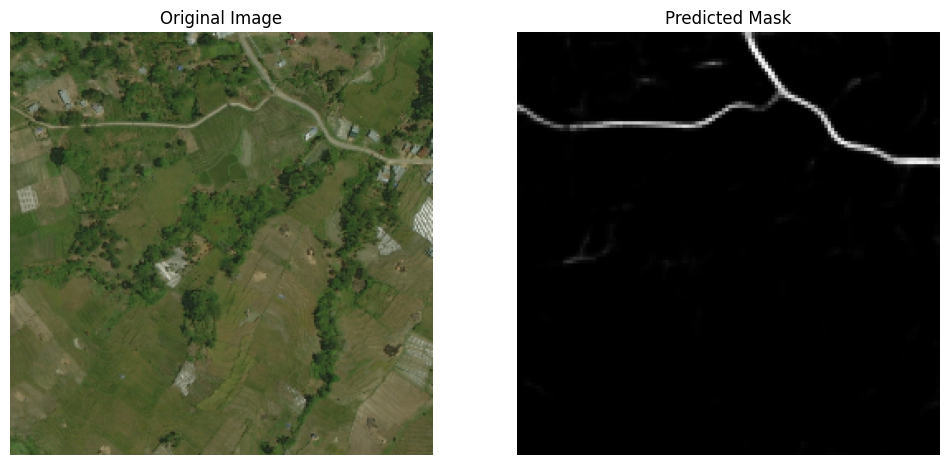

In [13]:
visualize_prediction(model, 'test/12416_sat.jpg')

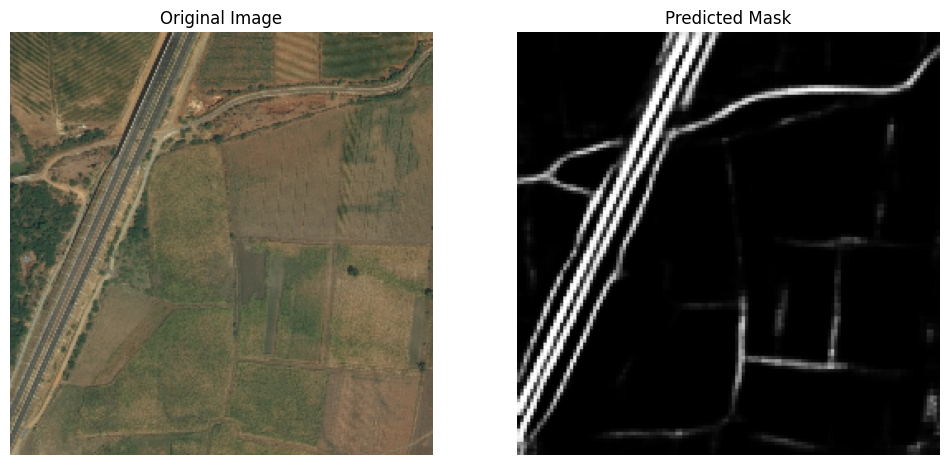

In [14]:
visualize_prediction(model, 'test/958252_sat.jpg')

### Lets test around more complex images from test data

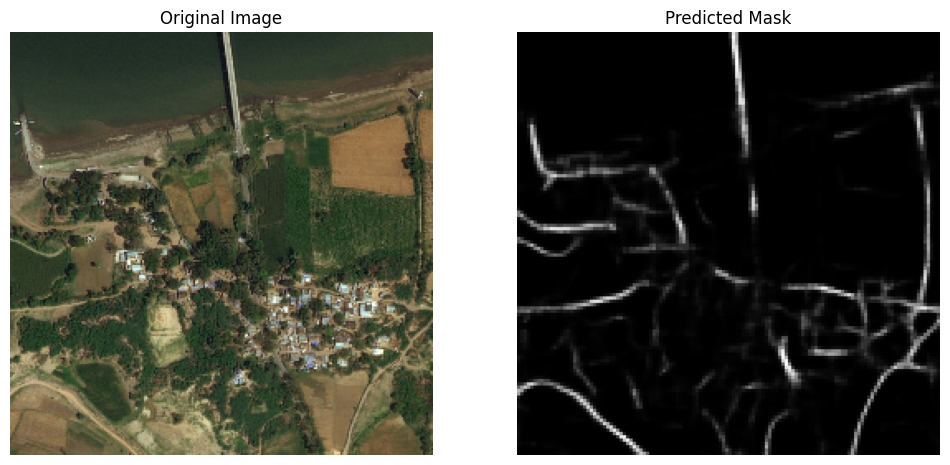

In [15]:
visualize_prediction(model, 'test/23785_sat.jpg')

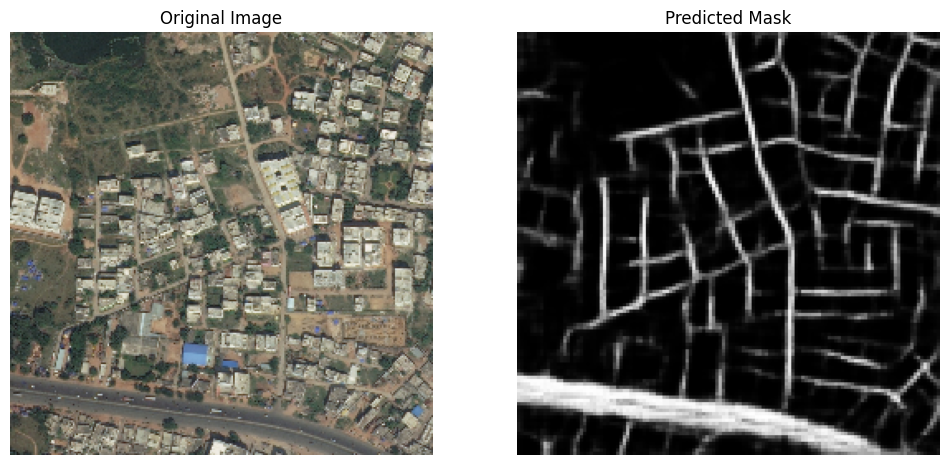

In [16]:
visualize_prediction(model, 'test/37358_sat.jpg')

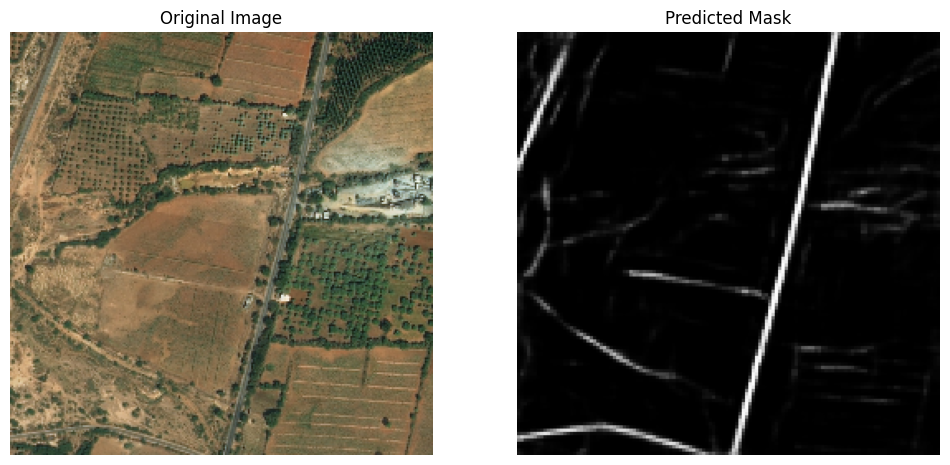

In [17]:
visualize_prediction(model, 'test/25089_sat.jpg')

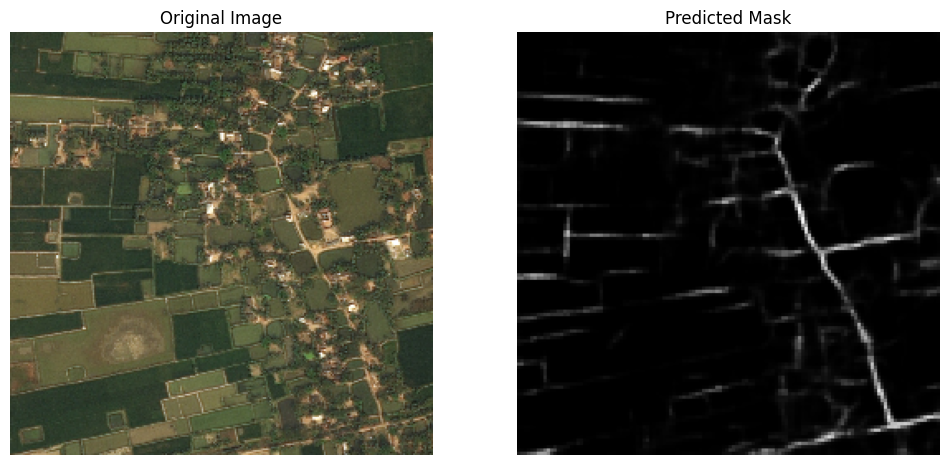

In [18]:
visualize_prediction(model, 'test/38385_sat.jpg')